# Estimator validation

This notebook contains code to generate estimation part of Figure 2 of the paper. 

This notebook also serves to compare the estimates of the re-implemented memento with sceb package from Vasilis. 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', 100)
import pickle as pkl
import time
from functools import reduce

/tmp/ipykernel_1697/2379830591.py:11: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-small',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'xx-small',
         'ytick.labelsize':'xx-small'}
pylab.rcParams.update(params)


In [3]:
import sys
sys.path.append('/home/ubuntu/Github/scrna-parameter-estimation/')
import memento
import memento.simulate as simulate

In [4]:
# import sys
# sys.path.append('/home/ssm-user/Github/single_cell_eb/')
# sys.path.append('/home/ssm-user/Github/single_cell_eb/sceb/')
# import scdd

In [5]:
data_path = '/home/ubuntu/Data/'
fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig3/'

In [6]:
%load_ext autoreload

In [7]:
%autoreload 2

### Extract parameters from interferon dataset

In [9]:
adata = sc.read(data_path + 'interferon_filtered.h5ad')
adata = adata[adata.obs.cell_type == 'CD4 T cells - ctrl']
data = adata.X.copy()
relative_data = data.toarray()/data.sum(axis=1)

/home/ubuntu/anaconda3/envs/mementocxg/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [10]:
q = 0.07
x_param, z_param, Nc, good_idx = memento.simulate.extract_parameters(adata.X, q=q, min_mean=0.01)

### Comparison function

In [11]:
def compare_mean_esimators(q, true_data):
    
    q_sq = 1e-10 + q**2 # very little variance in q's - assumption
    true_relative_data = true_data / true_data.sum(axis=1).reshape(-1, 1)
    m_true = true_relative_data.mean(axis=0)

    qs, captured_data = memento.simulate.capture_sampling(true_data, q, q_sq)
    Nr = captured_data.sum(axis=1).mean()
    captured_relative_data = captured_data/captured_data.sum(axis=1).reshape(-1, 1)
    adata = sc.AnnData(sp.sparse.csr_matrix(captured_data))
    # adata.write('/data_volume/memento/simulation/estimation/estimation_{}.h5ad'.format(q))
    sf = memento.estimator._estimate_size_factor(adata.X, 'hyper_relative', total=True, shrinkage=0.0)

    good_idx = (captured_data.sum(axis=0) > 0)

    # Compute 1D moments
    m_obs, v_obs = captured_relative_data.mean(axis=0), captured_relative_data.var(axis=0)
    m_poi, v_poi = memento.estimator._poisson_1d_relative(adata.X, size_factor=sf, n_obs=true_data.shape[0])
    m_hyp, _ = memento.estimator._good_mean_only(adata.X, size_factor=sf, n_obs=true_data.shape[0], q=q)
    # _, v_hyp = memento.estimator._hyper_1d_relative(adata.X, size_factor=sf, n_obs=true_data.shape[0], q=q)

    mean_list = [m_obs, m_poi, m_hyp, m_true]

    return good_idx, mean_list

### Concordance

In [16]:
def compute_mse(x, y, log=True):
    
    if log:
        return np.nanmean(np.abs(np.log(x)-np.log(y)))
    else:
        return np.nanmean(np.abs(x-y))

def concordance(x, y, log=True):
    
    if log:
        a = np.log(x)
        b = np.log(y)
    else:
        a = x
        b = y
    cond = np.isfinite(a) & np.isfinite(b)
    a = a[cond]
    b = b[cond]
    cmat = np.cov(a, b)
    return 2*cmat[0,1]/(cmat[0,0] + cmat[1,1] + (a.mean()-b.mean())**2)

In [17]:
n_cells = 100

In [18]:
A = np.random.random((n_cells, z_param[0].shape[0]))
cov = np.cov(A, rowvar=False)
# corr = corr*2
# corr[corr > 1] = 1

In [19]:
true_data = memento.simulate.simulate_transcriptomes(n_cells=n_cells, means=z_param[0], variances=z_param[1], Nc=Nc, norm_cov='uncorrelated')
true_data[true_data < 0] = 0
true_relative_data = true_data / true_data.sum(axis=1).reshape(-1, 1)
true_mean = z_param[0]/z_param[0].sum()

In [20]:
concordance(z_param[0]/Nc.mean(), true_relative_data.mean(axis=0))

/tmp/ipykernel_1697/4277250058.py:12: RuntimeWarning: divide by zero encountered in log
  b = np.log(y)


0.9598705260063135

In [21]:
concordance(z_param[0]/z_param[0].sum(), true_relative_data.mean(axis=0))

/tmp/ipykernel_1697/4277250058.py:12: RuntimeWarning: divide by zero encountered in log
  b = np.log(y)


0.9594705484848858

/tmp/ipykernel_1697/2218715421.py:1: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(x_param[0]), np.log(true_relative_data.mean(axis=0)))


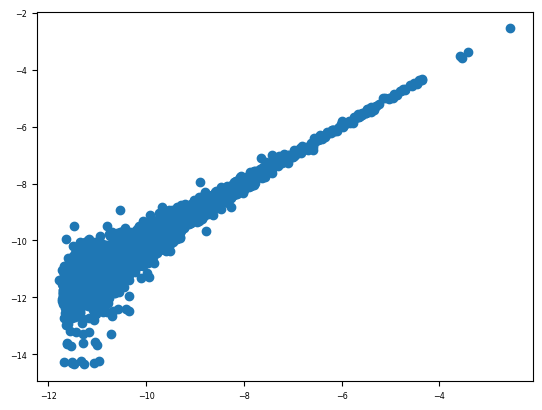

In [22]:
plt.scatter(np.log(x_param[0]), np.log(true_relative_data.mean(axis=0)))

In [23]:
# sc.AnnData(X=true_data, obs=pd.DataFrame(index=np.arange(10000)), var=pd.DataFrame(index=np.arange(true_data.shape[1])))\
#     .write('/data_volume/memento/simulation/estimation/estimation.h5ad')

In [45]:

    
q_list = [0.01, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.35, 0.5]
# results = [compare_mean_esimators(q, true_data=true_data) for q in q_list]
# good_idxs = reduce(lambda x,y: x & y, [r[0] for r in results])
m_mse_list1 = []
m_mse_list2 = []

for q in q_list:
    good_idxs, means = compare_mean_esimators(q, true_data=true_data)
    m_mse_list1.append([stats.pearsonr(np.log(x[good_idxs]), np.log((x_param[0])[good_idxs]))[0] for x in means])
    m_mse_list2.append([concordance(np.log(x[good_idxs]), np.log((x_param[0])[good_idxs]), log=False) for x in means])
    break
    
m_mse_list1 = np.array(m_mse_list1)
m_mse_list2 = np.array(m_mse_list2)

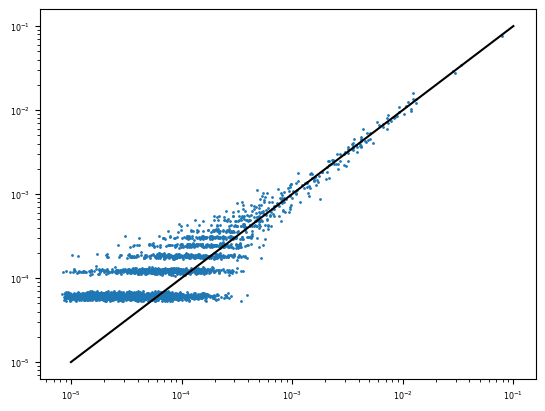

In [52]:
plt.scatter(
    true_mean[good_idxs],
    means[0][good_idxs],
    s=1
)
plt.yscale('log')
plt.xscale('log')
plt.plot([1e-5, 0.1], [1e-5, 0.1], color='k')

In [51]:
1/Nc.mean()

5.921218420216612e-05

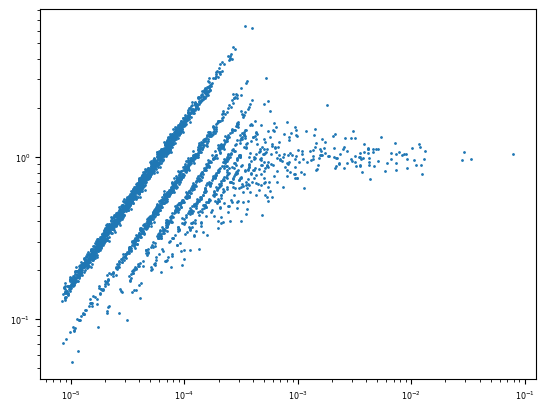

In [47]:
plt.scatter(
    true_mean[good_idxs],
    true_mean[good_idxs]/means[0][good_idxs],
    s=1
)
plt.yscale('log')
plt.xscale('log')
# plt.plot([1e-4, 0.1], [1e-4, 0.1], color='k')

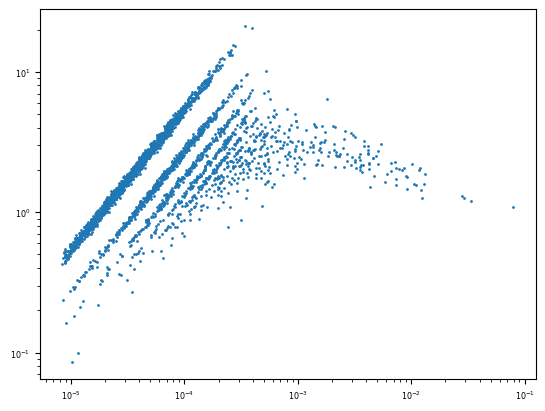

In [48]:
plt.scatter(
    true_mean[good_idxs],
    true_mean[good_idxs]/means[2][good_idxs],
    s=1
)
plt.yscale('log')
plt.xscale('log')
# plt.plot([1e-4, 0.1], [1e-4, 0.1], color='k')

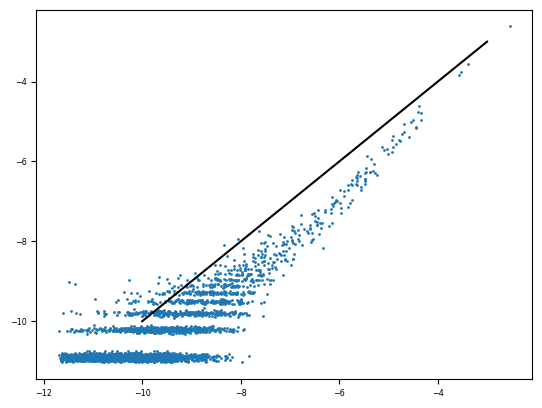

In [49]:
plt.scatter(
    np.log(true_mean[good_idxs]),

    np.log(means[2][good_idxs]),
    s=1
)
plt.plot([-10, -3], [-10, -3], color='k')

In [29]:
m_mse_list2

array([[0.72465136, 0.72465136, 0.61475469, 0.98010632]])

In [64]:
techs = {
    '10x_v1':0.08/2,
    '10x_v2':0.15/2,
    '10x_v3':0.32/2,
    'Smart-seq3':0.68/2
}

In [117]:
m_mse_list

[[0.9946829298654348,
  0.9946829298654348,
  0.9423547785447047,
  0.9997291459484937],
 [0.9977377506660153,
  0.9977377506660153,
  0.95525352903579,
  0.9997291459484937],
 [0.9988112692749737,
  0.9988112692749734,
  0.9680652316183855,
  0.9997291459484937],
 [0.9993034069913311,
  0.9993034069913311,
  0.9782887769854357,
  0.9997291459484937],
 [0.999463306149348,
  0.999463306149348,
  0.9825001357973223,
  0.9997291459484937],
 [0.999555575541054,
  0.999555575541054,
  0.9851219264771577,
  0.9997291459484937],
 [0.999567110730526, 0.999567110730526, 0.98693478502566, 0.9997291459484937],
 [0.9996422510724219,
  0.9996422510724221,
  0.9894973801736872,
  0.9997291459484937],
 [0.9996644030170726,
  0.9996644030170724,
  0.9918226240472564,
  0.9997291459484937]]

(0.9, 1.01)

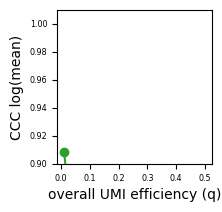

In [66]:
plt.figure(figsize=(2, 2))
start=0
plt.plot(q_list[start:], m_mse_list[:, 0][start:], '-o')
plt.plot(q_list[start:], m_mse_list[:, 1][start:], '-o')
plt.plot(q_list[start:], m_mse_list[:, 2][start:], '-o')

# plt.legend(['Naive,\nPoisson,\nHG'])
plt.ylabel('CCC log(mean)')
plt.xlabel('overall UMI efficiency (q)')
plt.ylim(0.9, 1.01)

(0.15, 1.05)

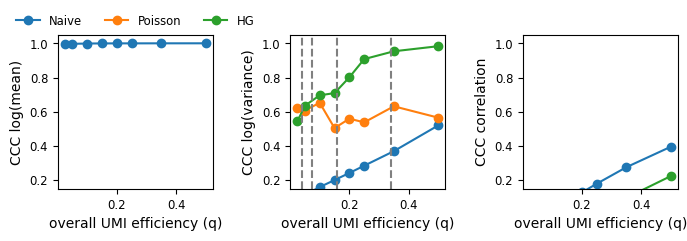

In [25]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

plt.figure(figsize=(8, 2))
plt.subplots_adjust(wspace=0.5)

plt.subplot(1, 3, 1)
plt.plot(q_list[1:], m_mse_list[:, 0][1:], '-o')
# plt.legend(['Naive,\nPoisson,\nHG'])
plt.ylabel('CCC log(mean)')
plt.xlabel('overall UMI efficiency (q)')
plt.ylim(0.15, 1.05)

start = 1
plt.subplot(1, 3, 2)
plt.plot(q_list[start:], v_mse_list[:, 0][start:], '-o')
plt.plot(q_list[start:], v_mse_list[:, 1][start:], '-o')
plt.plot(q_list[start:], v_mse_list[:, 2][start:], '-o')

for tech, capture in techs.items():
    plt.plot([capture, capture], [0.15, 1.05], '--', color='grey')

plt.legend(['Naive', 'Poisson', 'HG'], ncol=3, loc='upper center', bbox_to_anchor=(-1,1.2), frameon=False)
plt.ylabel('CCC log(variance)')
plt.xlabel('overall UMI efficiency (q)')
plt.ylim(0.15, 1.05)


plt.subplot(1, 3, 3)
plt.plot(q_list[start:], c_mse_list[:, 0][start:], '-o')
plt.plot(q_list[start:], c_mse_list[:, 1][start:], '-o')
plt.plot(q_list[start:], c_mse_list[:, 2][start:], '-o')
# plt.legend(['Naive', 'Poisson', 'HG'])
plt.ylabel('CCC correlation')
plt.xlabel('overall UMI efficiency (q)')
plt.ylim(0.15, 1.05)


# plt.savefig('estimation_efficiencies.pdf', bbox_inches='tight')